# Goal: Dig further into coupling index as a metric of L-A coupling. 
Note that this is similar to previous notebook, <i>ExploreData.ipynb</i>, but is cleaned up and organized to focus just on this metric. 
<br>
<br>
<b>Author:</b> Meg D. Fowler <br>
<b>Date:</b> 17 Aug 2020

**Import libraries**

In [22]:
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in helpful data

In [2]:
# Set directories and file names 
dailyDir   = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/day/'
middleName = '_day_CESM2_amip_r10i1p1f1_gn_'
varNames   = ['hfls','hfss','mrso','mrsos','tas','hurs','ps']

# Set time period portion of fileNames (Limited here to 1970-2014)
timeName_flx  = ['19700101-19791231','19800101-19891231', 
                 '19900101-19991231','20000101-20091231','20100101-20150101']

timeName_soil = ['19500101-19991231','20000101-20150101']


In [3]:
# Read in surface fluxes (latent and sensible heat)

for iT in range(len(timeName_flx)):

    # --- Compile surface fluxes into singe large arrays in time 

    # Latent heat flux
    lhFile       = dailyDir+varNames[0]+middleName+timeName_flx[iT]+'.nc' # File name
    lhDF         = xr.open_dataset(lhFile,decode_times=True) 
    lhDF['time'] = lhDF.indexes['time'].to_datetimeindex()

    # Sensible heat flux
    shFile       = dailyDir+varNames[1]+middleName+timeName_flx[iT]+'.nc' # File name
    shDF         = xr.open_dataset(shFile,decode_times=True)
    shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    if iT==0:
        lhflx_full = lhDF 
        shflx_full = shDF
    else:
        lhflx_full = xr.concat([lhflx_full, lhDF], dim="time")
        shflx_full = xr.concat([shflx_full, shDF], dim="time")
        
    print('Done with ', timeName_flx[iT])
    
# Get lat and lon 
lat = shDF.lat.values
lon = shDF.lon.values 
    

/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'hfls' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Converting a CFTimeIndex with dat

Done with  19700101-19791231
Done with  19800101-19891231
Done with  19900101-19991231
Done with  20000101-20091231
Done with  20100101-20150101


In [4]:
# Read in 10cm soil moisture

for iT in range(len(timeName_soil)):
    
    # 10 cm SM 
    soil10File = dailyDir+varNames[3]+middleName+timeName_soil[iT]+'.nc' # File name
    soil10DF   = xr.open_dataset(soil10File,decode_times=True)
    soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()
    
    if iT==0:
        soilM10_full = soil10DF
    else: 
        soilM10_full = xr.concat([soilM10_full, soil10DF], dim="time")

    print('Done with ', timeName_soil[iT])

/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


Done with  19500101-19991231
Done with  20000101-20150101


In [7]:
# Load pressure level of LCL (computed separately in Get_LCLpressure.py and saved as pickle file)
lclPath = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure_1950-2014.p'
Plcl    = pickle.load( open( lclPath, "rb" ) )


In [8]:
# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_coupling  = xr.open_dataset('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_1970-2015.nc', decode_times=False)
terraLeg_coupling = xr.open_dataset('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_1970-2015.nc', decode_times=False)
terraLH_coupling  = xr.open_dataset('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_1970-2015.nc', decode_times=False)


# The total pathway sensitvity should be the product of terraLeg_coupling and atmoLeg_coupling
totalSensitivity = terraLeg_coupling.mrsos_hfss_CI * atmoLeg_coupling.hfss_Plcl_CI


## Make plots to match what's in Santanello et al. [2018] Fig. 7 

In [32]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList_SMvLHF = [(127,58,144), 
                     (67,81,163),
                     (0,191,243),
                     (194,229,220),
                     (124,194,66),
                     (227,219,46),
                     (250,175,44),
                     (245,127,36), 
                     (239,67,54),
                     (238,45,122),
                     (162,6,66)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap_SMvLHF = make_cmap(colorsList_SMvLHF, bit=True)


In [42]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
LHcoupl_JJA = np.squeeze(np.asarray(terraLH_coupling.mrsos_hfls_CI[1,:,:]))
LHcoupl_DJF = np.squeeze(np.asarray(terraLH_coupling.mrsos_hfls_CI[0,:,:]))

# Make cyclic first 
LHcoupl_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA, lon)
LHcoupl_DJF_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF, lon)

# Now get color coded arrays 
colorsSMvLHF_JJA = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF = np.full([len(lat),len(lon)+1],np.nan)

# JJA 
colorsSMvLHF_JJA[np.where(LHcoupl_JJA_cyclic<-15)]                                = 1
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>-15) & (LHcoupl_JJA_cyclic<=-10))]  = 2
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>-10) & (LHcoupl_JJA_cyclic<=-5))]   = 3
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>-5)  & (LHcoupl_JJA_cyclic<=5))]    = 4
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>5)   & (LHcoupl_JJA_cyclic<=10))]   = 5
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>10)  & (LHcoupl_JJA_cyclic<=15))]   = 6
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>15)  & (LHcoupl_JJA_cyclic<=20))]   = 7
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>20)  & (LHcoupl_JJA_cyclic<=25))]   = 8
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>25)  & (LHcoupl_JJA_cyclic<=30))]   = 9
colorsSMvLHF_JJA[np.where((LHcoupl_JJA_cyclic>30)  & (LHcoupl_JJA_cyclic<=35))]   = 10
colorsSMvLHF_JJA[np.where(LHcoupl_JJA_cyclic>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF[np.where(LHcoupl_DJF_cyclic<-15)]                                = 1
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>-15) & (LHcoupl_DJF_cyclic<=-10))]  = 2
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>-10) & (LHcoupl_DJF_cyclic<=-5))]   = 3
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>-5)  & (LHcoupl_DJF_cyclic<=5))]    = 4
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>5)   & (LHcoupl_DJF_cyclic<=10))]   = 5
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>10)  & (LHcoupl_DJF_cyclic<=15))]   = 6
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>15)  & (LHcoupl_DJF_cyclic<=20))]   = 7
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>20)  & (LHcoupl_DJF_cyclic<=25))]   = 8
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>25)  & (LHcoupl_DJF_cyclic<=30))]   = 9
colorsSMvLHF_DJF[np.where((LHcoupl_DJF_cyclic>30)  & (LHcoupl_DJF_cyclic<=35))]   = 10
colorsSMvLHF_DJF[np.where(LHcoupl_DJF_cyclic>35)]                                 = 11




/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered 

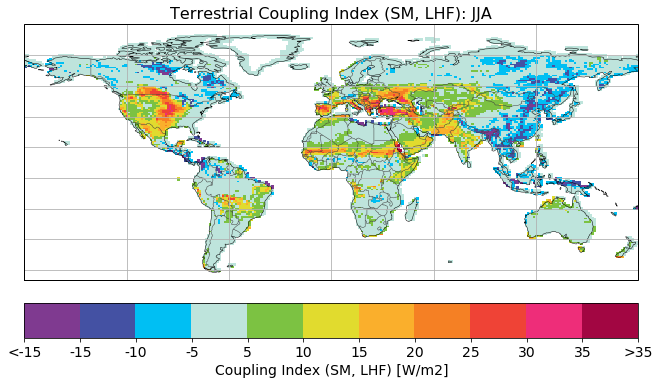

In [50]:
# --- Plot JJA SM,LHF coupling index

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, LHF) [W/m2]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-15','-15','-10','-5','5','10', '15','20','25','30','35','>35'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Terrestrial Coupling Index (SM, LHF): JJA',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




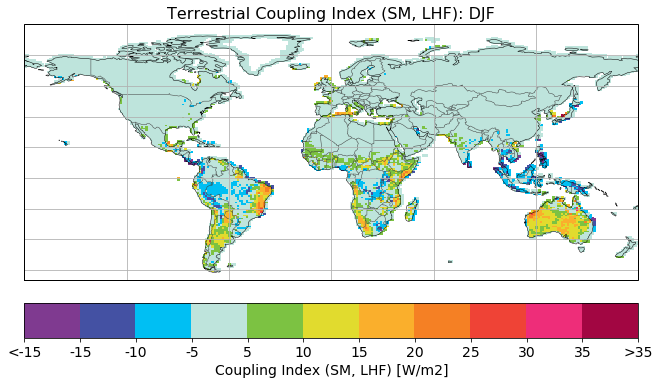

In [49]:
# --- Plot DJF SM,LHF coupling index

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.set_global()
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, LHF) [W/m2]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-15','-15','-10','-5','5','10', '15','20','25','30','35','>35'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Terrestrial Coupling Index (SM, LHF): DJF',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



## Make plots to match what's in Dirmeyer et al. [2014] Fig. 1

In [52]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


In [59]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA  = np.squeeze(np.asarray(atmoLeg_coupling.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA = np.squeeze(np.asarray(terraLeg_coupling.mrsos_hfss_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA, lon)
TerraLeg_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA, lon)

# Now get color coded arrays 
colorsAtmoLeg  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg = np.full([len(lat),len(lon)+1],np.nan)

# Atmo leg 
colorsAtmoLeg[np.where(AtmoLeg_JJA_cyclic<-150)]                                 = 1
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>-150) & (AtmoLeg_JJA_cyclic<=-100))]  = 2
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>-100) & (AtmoLeg_JJA_cyclic<=-50))]   = 3
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>-50)  & (AtmoLeg_JJA_cyclic<=-20))]   = 4
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>-20)  & (AtmoLeg_JJA_cyclic<=0))]     = 5
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>0)    & (AtmoLeg_JJA_cyclic<=20))]    = 6
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>20)   & (AtmoLeg_JJA_cyclic<=40))]    = 7
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>40)   & (AtmoLeg_JJA_cyclic<=60))]    = 8
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>60)   & (AtmoLeg_JJA_cyclic<=80))]    = 9
colorsAtmoLeg[np.where((AtmoLeg_JJA_cyclic>80)   & (AtmoLeg_JJA_cyclic<=100))]   = 10
colorsAtmoLeg[np.where(AtmoLeg_JJA_cyclic>100)]                                  = 11


# Terra leg  
colorsTerraLeg[np.where(TerraLeg_JJA_cyclic<-20)]                                 = 1
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-20) & (TerraLeg_JJA_cyclic<=-15))]  = 2
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-15) & (TerraLeg_JJA_cyclic<=-10))]  = 3
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-10) & (TerraLeg_JJA_cyclic<=-5))]   = 4
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-5) & (TerraLeg_JJA_cyclic<=-2))]    = 5
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-2) & (TerraLeg_JJA_cyclic<=-1))]    = 6
colorsTerraLeg[np.where((TerraLeg_JJA_cyclic>-1) & (TerraLeg_JJA_cyclic<=0))]     = 7
colorsTerraLeg[np.where(TerraLeg_JJA_cyclic>0)]                                   = 8


/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Users/meganfowler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfo

In [68]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic))] = 1


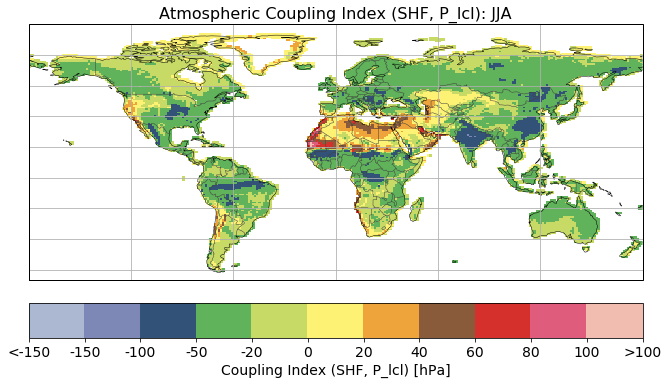

In [70]:
# --- Plot JJA Atmopsheric leg 

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,lat,colorsAtmoLeg*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Atmospheric Coupling Index (SHF, P_lcl): JJA',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



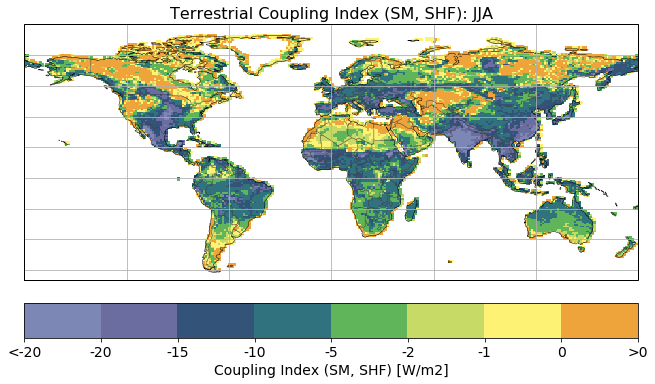

In [72]:
# --- Plot JJA Terrestrial leg 

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,lat,colorsTerraLeg,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Terrestrial Coupling Index (SM, SHF): JJA',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


